In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import torchvision.transforms.functional as Fr
import torch.nn.functional
import matplotlib.pyplot as plt
import time
import os
import copy

In [ ]:
class SquarePad:
    def __call__(self, image):
        """
        Args:
            img (PIL Image): Image to be padded.

        Returns:
            PIL Image: Padded image.
            
        """
        w, h = image.size
        max_wh = np.max([w, h])
        hp = int((max_wh - w) / 2)
        vp = int((max_wh - h) / 2)
        padding = (hp, vp, hp, vp)
        return Fr.pad(image, padding, 0, 'constant')

target_image_size = (224, 224)  # as an example
# now use it as the replacement of transforms.Pad class
#Data Augmentation and normalization for training
# and only Normalization for validation
data_transforms = {
    'train': transforms.Compose([
        SquarePad(),
        transforms.Resize(target_image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        SquarePad(),
        transforms.Resize(target_image_size),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cpu


In [ ]:
from google.colab import drive
drive._mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_dir = '/content/drive/MyDrive/dataset'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True)
              for x in ['train', 'val']}

In [ ]:
#Dataset sizes and classes names
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

#### Visulaize a few images

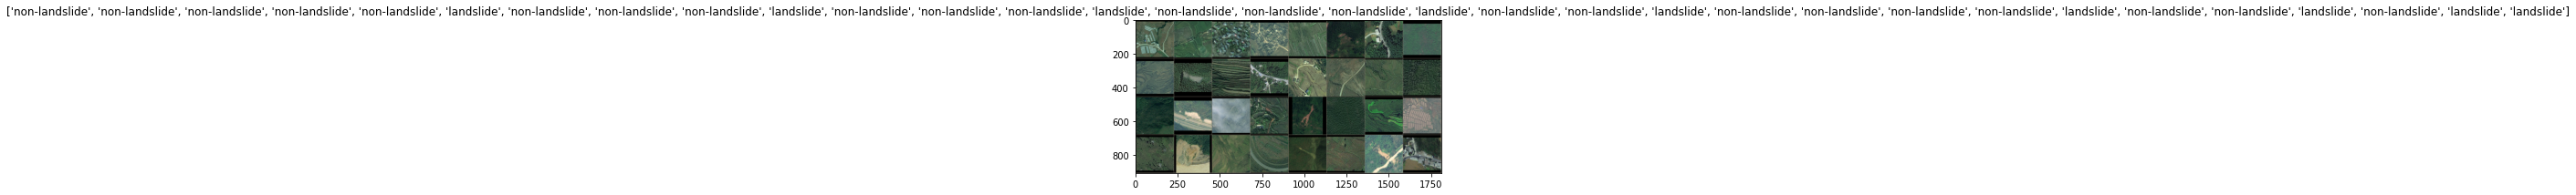

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [ ]:
dataiter = iter(dataloaders['val'])
images, labels = dataiter.next()
print(torch.mean(images), torch.max(images))

tensor(-0.5261) tensor(2.6051)


### Define Model




Spatial size of output: 
$\frac{K*(W-F+2P)}{(S+1)}$

`W - input volume size `
<br>
`F the receptive field size of the Conv Layer neurons i.e kernel size`
<br>
`S - the stride with which they are applied `
<br>
`P - the amount of zero padding used on the border `
<br>
`K - the depth/channel of conv layer.`

In [ ]:
#Defining architecture.
class Autoencoder(nn.Module):
  def __init__(self):
    super(Autoencoder, self).__init__()
    #encoder layers
    self.encoder = nn.Sequential(
        nn.Conv2d(3, 16, 3, stride = 2, padding = 1),
        nn.ReLU(),
        nn.Conv2d(16, 32, 3, stride =2, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 64, 7),
                           #Conv2d(in_channels, out_channels, kernel_size)
    )
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(64, 32, 7),
        nn.ReLU(),
        nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
        # nn.Sigmoid()
    )

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x    

In [ ]:
model = Autoencoder()
model = model.to(device)

In [ ]:
print(model)

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)


In [ ]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
print(device)

cpu


In [ ]:
# number of epochs to train the model
n_epochs = 100

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in dataloaders['train']:
        # _ stands in for labels, here
        # no need to flatten images
        images, _ = data
        images = images.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(dataloaders['train'])
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

Epoch: 1 	Training Loss: 11.378868
Epoch: 2 	Training Loss: 3.457300
Epoch: 3 	Training Loss: 2.438680
Epoch: 4 	Training Loss: 1.870757
Epoch: 5 	Training Loss: 1.534634
Epoch: 6 	Training Loss: 1.351257
Epoch: 7 	Training Loss: 1.253962
Epoch: 8 	Training Loss: 1.092755
Epoch: 9 	Training Loss: 0.959371
Epoch: 10 	Training Loss: 0.949613
Epoch: 11 	Training Loss: 0.816113
Epoch: 12 	Training Loss: 0.762858
Epoch: 13 	Training Loss: 0.735564
Epoch: 14 	Training Loss: 0.699433
Epoch: 15 	Training Loss: 0.669112
Epoch: 16 	Training Loss: 0.739055


KeyboardInterrupt: ignored

In [ ]:
!tensorboard --version

In [ ]:
%load_ext tensorboard


In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [ ]:
img = image_datasets['train'][0][0]
img = img.unsqueeze(0)
writer.add_graph(model, )

In [ ]:
%tensorboard --logdir=runs/